# NVIDIA LSTM Forecasting

## Setup

In [9]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Now we load in the time series data for and cut it down to a 5 year period for 2018 to 2023 and store it in the datafram called 'df'

In [10]:
# Read the csv file into a pandas DataFrame
df_ret = pd.read_csv('../DataManagement/daily_data.csv', parse_dates=['DATE'], index_col='DATE')
df_exog = pd.read_csv('../DataManagement/nvidia_exogenous.csv', parse_dates=['DATE'], index_col='DATE')

# Specify the date range
start_date = '2018-06-30'
end_date = '2023-06-30'

# Slice the DataFrame for the desired date range
df_ret = df_ret.loc[start_date:end_date]
df_exog = df_exog.loc[start_date:end_date]

We pull in the following exogenous data:
* NVDA_EPS_WS_EST
* NVDA_EPS_ACT
* NVDA_EPS_SURPRISE
* NVDA_EPS_FLAG
* NVDA_DAYS_SINCE_EPS
* NVDA_VOLUME

In [11]:
# ['NVDA_EPS_WS_EST', 'NVDA_EPS_ACT', 'NVDA_EPS_SURPRISE', 'NVDA_EPS_FLAG', 'NVDA_DAYS_SINCE_EPS', 'NVDA_VOLUME']
variable_selection = ['NVDA_EPS_SURPRISE']

returns = df_ret['NVDA_RET'].copy()
exog_data = df_exog[variable_selection].copy()

returns.index = pd.DatetimeIndex(returns.index).to_period('D')
exog_data.index = pd.DatetimeIndex(exog_data.index).to_period('D')

Then we prepare a train/test split for the Nvidia log return series which we will use later for fitting and testing the ARMA and GARCH models. In this instance, we cut the last 60 days for testing and the rest is used for training.

In [12]:
train, test = returns[:-60], returns[-60:]
exog_train, exog_test = exog_data[:-60], exog_data[-60:]

Here we set some formatter configurations to help with plotting graphs later on

In [13]:
month_year_formatter = mdates.DateFormatter('%Y-%m')
locator = mdates.MonthLocator(interval=3)

## Data Pre-Processing

When transitioning from traditional time series analysis techniques like ARMA to more advanced methods like LSTM for forecasting stock prices, the choice of data representation becomes an important consideration. While using log returns is a common approach in ARMA modeling to achieve stationarity, the same concept does not necessarily apply directly to LSTM models.

In an ARMA model, the logarithmic transformation is often used to stabilize the variance of the time series and make it stationary. The ARMA model assumes that the data has constant variance and the logarithmic transformation helps in achieving this property for certain financial time series, including stock prices.

However, LSTM models are designed to handle more complex dependencies and can capture long-term patterns and non-linear relationships. These models are capable of handling non-stationary data to some extent. Therefore, it is not a strict requirement to use log returns in an LSTM model for stock price forecasting.

The choice of input representation (log returns, simple returns, or prices) for an LSTM model depends on various factors, including the characteristics of the data and the specific problem you are trying to solve:

1. **Log Returns:** Log returns are commonly used when you want to stabilize the variance of the data and make it stationary. This can be helpful when you are using traditional statistical models like ARMA or when the stock price series exhibits strong volatility clustering. However, LSTM models have the ability to implicitly handle some non-stationarity, so using log returns may not be necessary in all cases.

2. **Simple Returns:** Simple returns (percentage changes in prices) are a straightforward representation and can be directly used as inputs to an LSTM model. They have the advantage of being interpretable and are often used in practice for forecasting financial time series with deep learning models.

3. **Prices:** Using raw prices as inputs to an LSTM model can be informative as it includes the original levels of the data. However, using prices directly may introduce spurious correlations and trends, which can negatively impact the model's performance. It is generally recommended to use some form of returns when dealing with financial time series to avoid this issue.

Dealing with data on different scales and different data types is a common challenge in many machine learning and forecasting tasks, including time series analysis with LSTM models. It is important to handle these differences appropriately to ensure that the model can effectively learn from the data and make accurate predictions. Here are some strategies to handle data with varying scales and types:

1. **Normalization/Standardization:** One way to handle data on different scales is to normalize or standardize the numerical features. Normalization scales the data to a range between 0 and 1, while standardization transforms the data to have zero mean and unit variance. This process helps the model by giving equal importance to all features regardless of their original scales. You can apply normalization or standardization to the numerical features before feeding them into the LSTM model.

2. **Categorical Variables:** For categorical variables like the earnings call flag (0 or 1), you should convert them to one-hot encodings. This means creating new binary columns for each category and indicating the presence (1) or absence (0) of that category. In the case of the earnings call flag, you would have two new columns: "Earnings_Call_Yes" and "Earnings_Call_No."

3. **Handling Binary Data in LSTM:** For handling binary data in LSTM, you can represent binary features using a single binary input neuron (0 or 1) instead of one-hot encoding. LSTM models can naturally work with binary inputs.

4. **Feature Scaling:** If you have a mix of numerical and one-hot encoded categorical features, ensure that they are all on a similar scale. After one-hot encoding, the binary features will already be on the same scale (0 or 1), but numerical features should be normalized or standardized, as mentioned earlier.

5. **Handling Time Series and Exogenous Data:** If you have multiple types of data (e.g., time series returns and exogenous features like EPS figures and trade volume), you can use a multi-input LSTM architecture. In this setup, you provide different inputs for the LSTM model to process. One input stream will be the time series returns, and the other input streams will be the exogenous features. The LSTM can learn to combine and utilize information from both sources.

6. **Data Integration:** Ensure that your data is aligned properly. The time series returns and exogenous features should be synchronized by their timestamps so that the LSTM can effectively understand the relationships between them.

7. **Loss Function and Output Layer:** Depending on the specific forecasting task (e.g., regression or classification), choose an appropriate loss function and output layer for the LSTM. For regression tasks, mean squared error (MSE) is often used, while for classification tasks, binary cross-entropy or categorical cross-entropy may be used.

## LSTM Model

Here we define a function for generating sequences.

In [14]:
def create_dataset(X, Y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = np.array(X.iloc[i:(i + time_steps)])
        Xs.append(v)
        ys.append(Y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

We concatenate the return column from the "train" and "test" dataframes with the corresponding exogenous dataframes.

In [15]:
exog_train['returns'] = train.values
exog_test['returns'] = test.values

c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\hello\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Prepare the sequences of input data and scale (standardise) them:

In [16]:
time_steps = 5

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# fit and transform only on the returns column
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# create sequences using scaled data
X_train_scaled, y_train_scaled = create_dataset(exog_train, pd.DataFrame(train_scaled, index=train.index, columns=['returns']), time_steps)
X_test_scaled, y_test_scaled = create_dataset(exog_test, pd.DataFrame(test_scaled, index=test.index, columns=['returns']), time_steps)

Now we train the LSTM model with "X_train" and "y_train".

In [17]:
n_features = X_train_scaled.shape[2]  # number of features

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)


Epoch 1/50
38/38 [==============================] - 3s 7ms/step - loss: 1.0034
Epoch 2/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0042
Epoch 3/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0034
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0041
Epoch 5/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0039
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0036
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0031
Epoch 8/50
38/38 [==============================] - 0s 8ms/step - loss: 1.0038
Epoch 9/50
38/38 [==============================] - 0s 8ms/step - loss: 1.0033
Epoch 10/50
38/38 [==============================] - 0s 8ms/step - loss: 1.0034
Epoch 11/50
38/38 [==============================] - 0s 8ms/step - loss: 1.0042
Epoch 12/50
38/38 [==============================] - 0s 7ms/step - loss: 1.0035
Epoch 13/50
38/38 [==============================

Finally, we generate predictions using "X_test" and compare the results with "y_test".

In [18]:
predicted_returns_scaled = model.predict(X_test_scaled)

2/2 [==============================] - 0s 3ms/step


In [19]:
# Unscale the test data and predicted data
y_test = scaler.inverse_transform(y_test_scaled)
predicted_returns = scaler.inverse_transform(predicted_returns_scaled)

Fetch the dates of the test period.

In [20]:
# Extract corresponding dates
test_dates = test.index[time_steps:]
test_dates = test_dates.to_timestamp()

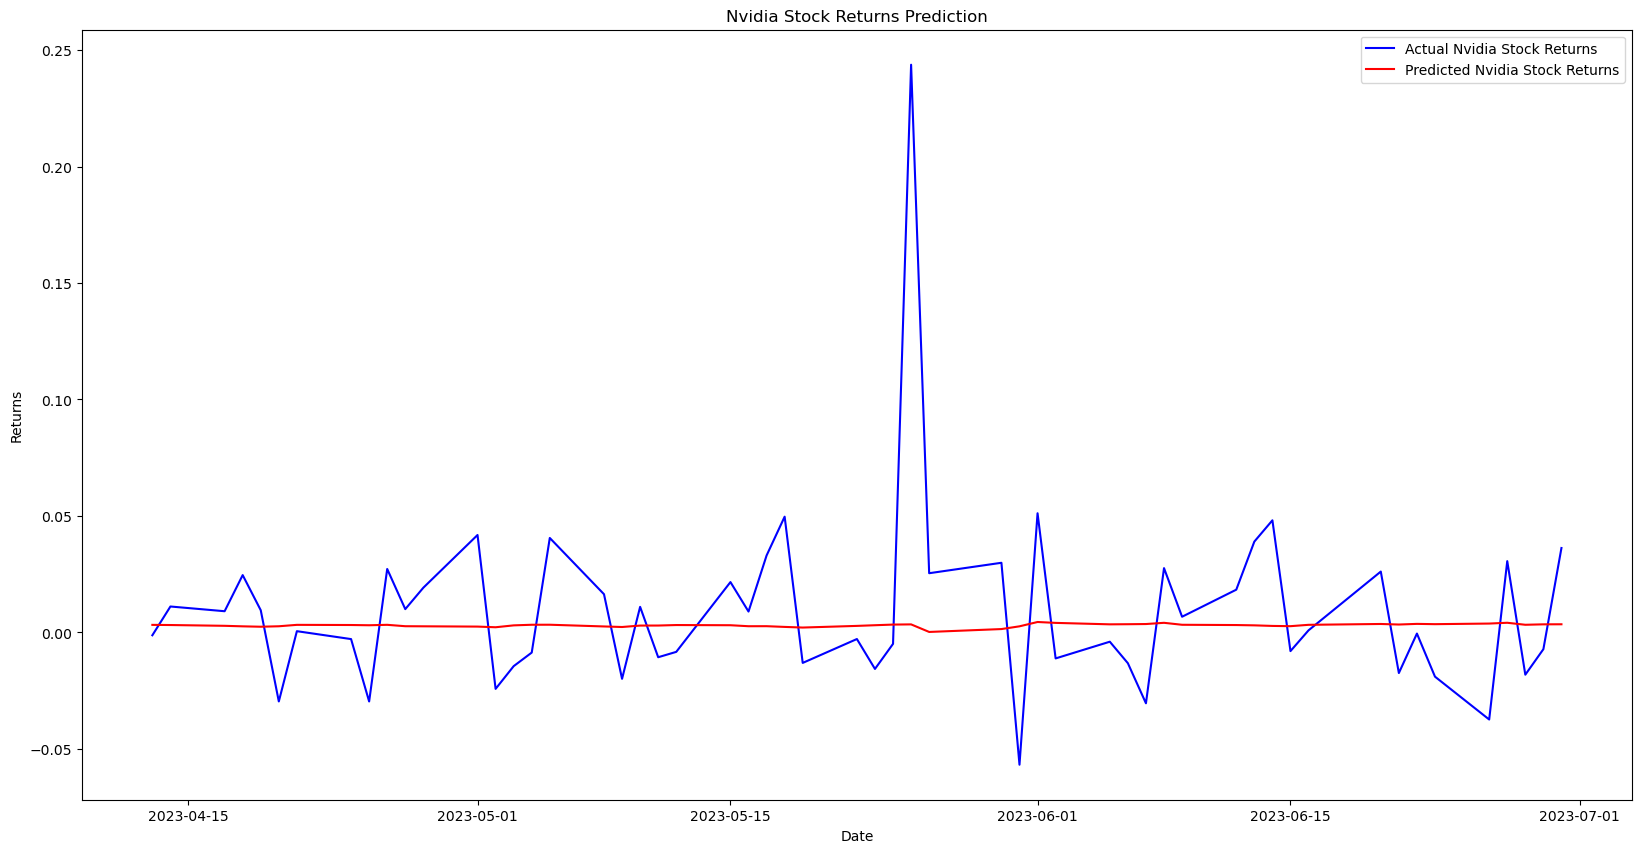

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(test_dates, y_test, color='blue', label='Actual Nvidia Stock Returns')
plt.plot(test_dates, predicted_returns, color='red', label='Predicted Nvidia Stock Returns')
plt.title('Nvidia Stock Returns Prediction')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
